# Notebook with various tests of the GPT code

In [2]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [5]:
#!pip install datasets tqdm

In [18]:
#!pip install -r ../requirements.txt

In [1]:
# Set autoreload
%load_ext autoreload
%autoreload 2

from GPT import GPT, GPTConfig, Generator
from DataLoaderGPT import DataLoaderGPT
from LRScheduler import LRScheduler
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import os


Running GPT.py


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
config = GPTConfig()
config 


GPTConfig(block_size=1024, vocab_size=50304, n_layer=12, n_head=12, n_embd=768)

In [4]:
model = GPT(config)

In [5]:
# Resume a previous model if existing
#Find the latest model in the target folder
model_folder='../models/'
model_filter='model'
model_files = []
#Check if folder exists
if os.path.exists(model_folder):
    model_files = os.listdir(model_folder)
    model_files = [f for f in model_files if model_filter in f]

if len(model_files)==0:
    print('No previous model found. Starting fresh.')
    model = GPT(config)
    print('Model created...')
else:
    model_files.sort()
    latest_model = model_files[-1]
    latest_model=os.path.join(model_folder,latest_model)
    print('Loading model:', latest_model)
    model_data = torch.load(latest_model, weights_only=False, map_location=device)
    #dict_keys(['model', 'config', 'step', 'val_loss'])
    model = GPT(model_data['config'])
    model.load_state_dict(model_data['model'])
    print('Model loaded...')

Loading model: ../models/model_35000.pt
Model loaded...


In [6]:
latest_model

'../models/model_35000.pt'

In [7]:
# Count number of parameters
num_params = sum(p.numel() for p in model.parameters())
print('Number of parameters: {}'.format(num_params))

Number of parameters: 124475904


In [5]:
# Creata a random tensor with batch size 5
x = torch.randint(0, config.vocab_size, (5, config.block_size))
x

tensor([[43794, 28329, 18747,  ..., 11551, 16568, 39041],
        [24101, 36755, 13411,  ...,  7062,  6004, 35578],
        [37311, 18572, 21883,  ..., 19782, 37860, 39041],
        [41361, 35112,  8427,  ..., 39288,  3946, 31934],
        [32468,  7473,  1356,  ...,  3821, 48171, 33738]])

In [6]:
logits, loss = model(x)

In [7]:
logits.shape

torch.Size([5, 1024, 50257])

In [8]:
tokenizer = tiktoken.get_encoding('gpt2')

In [9]:

model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)

In [30]:
generator = Generator(model, tokenizer)

Running GPT.py


In [37]:
texts = generator.generate('The meaning of life is 42 ', max_len=100, top_k=50, num_return_sequences=2)
for text in texts:
    print(text)

The meaning of life is 42 _____ (7).
(8) [F]is a statement of action, not merely a reaction;
(9) The person is in the state of utterance, not as a consequence of actions;
(10) The person is still in the condition of utterance as a consequence of actions
(11) The person is in his state of utterance as a consequence of actions
(12) [E]is a statement of action, not a consequence of action;
The meaning of life is 42 
This is where the word gender comes in. Gender is the term for the ability to live a meaningful and rewarding life without suffering a condition that often occurs in domestic animals. Gender in animals and humans are also affected and sometimes it is important for females and therefore men to have the ability to live meaningful and rewarding lives.
In modern times, gender is defined as those characteristics which tend to determine individuals' gender identity and make it difficult to control and change. We know that men are not the


In [48]:
path = '../data/simple/'
B, T = 5, 10
process_rank = 0
num_processes = 1
split = 'train'
data_loader = DataLoaderGPT(B=B, T=T, process_rank=process_rank,num_processes=num_processes, split=split, data_root=path, is_text=True)

found 1 shards for split train


In [50]:
x, y = data_loader.next_batch()

In [51]:
x.shape

torch.Size([5, 10])

In [52]:
x

tensor([[ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11],
        [ 3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248],
        [  461,    11,  2740,    13,   198,   198,  5962, 22307,    25,   198],
        [ 1639,   389,   477, 12939,  2138,   284,  4656,   621,   284,  1145],
        [  680,    30,   198,   198,  3237,    25,   198,  4965,  5634,    13]])

In [53]:
y

tensor([[22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,  3285],
        [  502,  2740,    13,   198,   198,  3237,    25,   198,  5248,   461],
        [   11,  2740,    13,   198,   198,  5962, 22307,    25,   198,  1639],
        [  389,   477, 12939,  2138,   284,  4656,   621,   284,  1145,   680],
        [   30,   198,   198,  3237,    25,   198,  4965,  5634,    13, 12939]])

In [55]:
x = x.to(device)
y = y.to(device)
logits, loss = model(x,y)

In [57]:
loss

tensor(10.9079, device='cuda:0', grad_fn=<NllLossBackward0>)

# Test the LR Scheduler


In [65]:
lr_scheduler = LRScheduler(max_lr=6e-4, min_lr=6e-5,warmup_steps=10, max_steps=50)

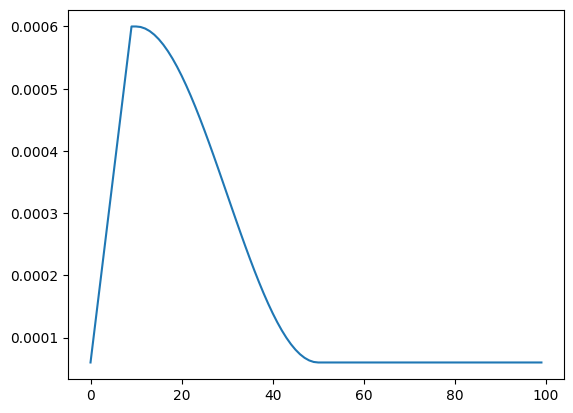

In [68]:
t = []
lrs =[]

for i in range(100):
    lr = lr_scheduler.get_lr(i)
    t.append(i)
    lrs.append(lr)

import matplotlib.pyplot as plt
plt.plot(t, lrs)